In [1]:
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn. functional as F
import torch.optim as optim
import os
import torchvision
import torchvision.transforms
from PIL import Image
import torchvision
from torch.distributions import Normal
from utils import train_vae, train_hvae, test_vae, test_hvae, clear_dir

### Task 1.

Ładowanie i preprocessing danych zaimplementowane zostały w pliku './utils.py'

In [2]:
from utils import get_project_data

train_loader, test_loader, val_loader = get_project_data()

Po załadowaniu danych warto zapisać je do plików przy pomocy komend niżej.

In [3]:
# torch.save(train_loader, './dataloaders/train_loader.pth')
# torch.save(test_loader, './dataloaders/test_loader.pth')
# torch.save(val_loader, './dataloaders/val_loader.pth')

In [4]:
# train_loader  = torch.load('./dataloaders/train_loader.pth')
# test_loader = torch.load('./dataloaders/test_loader.pth')
# val_loader = torch.load('./dataloaders/val_loader.pth')

Wizualizacja 3 pierwszych obrazków ze zbioru treningowego

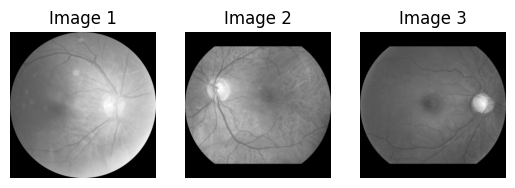

In [5]:
examples = next(iter(train_loader))

plt.subplot(1, 3, 1)
plt.imshow(torch.reshape(examples[0][0], (256,256)), cmap='gray')
plt.axis('off')
plt.title('Image 1')

plt.subplot(1, 3, 2)
plt.imshow(torch.reshape(examples[0][1], (256,256)), cmap='gray')
plt.axis('off')
plt.title('Image 2')

plt.subplot(1, 3, 3)
plt.imshow(torch.reshape(examples[0][2], (256,256)), cmap='gray')
plt.axis('off')
plt.title('Image 3')

plt.show()

Nasze dane składały się z kolorowych zdjęć o rozmiarze 512x512. Poddaliśmy je następującym transformacją:
- zmiana na skalę szarości
- wartość pikseli została znormalizowana do przedziału 0 - 1
- zdjęcia zostały przeskalowane do rozmiaru 256x256

Dane mają następujący rozkład:
- trening 0: 5293, 1: 3328
- test 0: 1754, 1: 1120
- val 0: 3539, 1: 2208

### Task 2.

Modele VAE i HVAE zostały zaimplementowane w plikach './models/vae.py' i './models/hvae.py'. 

### Task 3.

Na początku porównałem działanie zwykłego VAE do HVAE, czyli sprawdziłem jak dodanie dodatkowej warstwy ukrytej wpłynie na wyniki modelu. Zrekonstruowane obrazki ze zbioru testowego zostały zapisane do folderów './images_vae' oraz './images_hvae'.

In [6]:
from models.vae import VAE
from models.hvae import HVAE

torch.manual_seed(777)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run options
LEARNING_RATE = 1.0e-3

In [7]:
# setup model
model_hvae = HVAE(latent_1_size = 128, latent_2_size = 32, beta = 1)
model_vae = VAE(latent_1_size = 128, beta = 1)

optimizer_hvae = torch.optim.Adam(list(model_hvae.parameters()), lr=LEARNING_RATE)
optimizer_vae = torch.optim.Adam(list(model_vae.parameters()), lr=LEARNING_RATE)

In [8]:
EPOCH = 100

In [9]:
train_losses_hvae = []
test_losses_hvae = []

train_kld_hvae_list = []
test_kld_hvae_list = []

train_recon_hvae_list = []
test_recon_hvae_list = []

clear_dir('./images_hvae/')
for i in range(EPOCH):
    model_hvae.train()
    train_total_hvae, train_kld_hvae, train_reconstruction_hvae = train_hvae(model_hvae, train_loader, optimizer_hvae, device)
    with torch.no_grad():
        model_hvae.eval()
        test_total_hvae, test_kld_hvae, test_reconstrustion_hvae = test_hvae(i, model_hvae, test_loader, device, './images_hvae/')

    print("Epoch: {}/{} Train loss HVAE: {}, Train KLD: {}, Train Reconstruction Loss:{}".format(i, EPOCH, train_total_hvae, train_kld_hvae, train_reconstruction_hvae))
    print("Epoch: {}/{} Test loss HVAE: {}, Test KLD: {}, Test Reconstruction Loss:{}".format(i, EPOCH, test_total_hvae, test_kld_hvae, test_reconstrustion_hvae))

    train_losses_hvae.append([train_total_hvae])
    test_losses_hvae.append([test_total_hvae])

    train_kld_hvae_list.append([train_kld_hvae])
    test_kld_hvae_list.append([test_kld_hvae])

    train_recon_hvae_list.append([train_reconstruction_hvae])
    test_recon_hvae_list.append([test_reconstrustion_hvae])

Epoch: 0/100 Train loss HVAE: 182118.10258290076, Train KLD: 955.7495179985532, Train Reconstruction Loss:181162.35405391813
Epoch: 0/100 Test loss HVAE: 136248.4863322025, Test KLD: 1449.0178086739409, Test Reconstruction Loss:134799.46693415102
Epoch: 1/100 Train loss HVAE: 105305.70467145996, Train KLD: 4166.3171323779125, Train Reconstruction Loss:101139.38715498039
Epoch: 1/100 Test loss HVAE: 89836.24644985213, Test KLD: 5003.4748890239, Test Reconstruction Loss:84832.77211638831
Epoch: 2/100 Train loss HVAE: 90282.5831635686, Train KLD: 4739.651564105704, Train Reconstruction Loss:85542.93128765334
Epoch: 2/100 Test loss HVAE: 83771.15802235561, Test KLD: 4844.270140157446, Test Reconstruction Loss:78926.8879664666
Epoch: 3/100 Train loss HVAE: 83092.40251525164, Train KLD: 5040.926441910787, Train Reconstruction Loss:78051.47616784234
Epoch: 3/100 Test loss HVAE: 84133.47406163013, Test KLD: 5252.581987416819, Test Reconstruction Loss:78880.89168786969
Epoch: 4/100 Train loss H

In [10]:
train_losses_vae = []
test_losses_vae = []

train_kld_vae_list = []
test_kld_vae_list= []

train_recon_vae_list = []
test_recon_vae_list= []

clear_dir('./images_vae/')
for i in range(EPOCH):
    model_vae.train()
    train_total_vae, train_kld_vae, train_reconstrustion_vae = train_vae(model_vae, train_loader, optimizer_vae, device)
    with torch.no_grad():
        model_vae.eval()
        test_total_vae, test_kld_vae, test_reconstrustion_vae = test_vae(i, model_vae, test_loader, device, './images_vae/')

    print("Epoch: {}/{} Train loss VAE: {}, Train KLD: {}, Train Reconstruction Loss:{}".format(i, EPOCH, train_total_vae, train_kld_vae, train_reconstrustion_vae))
    print("Epoch: {}/{} Test loss VAE: {}, Test KLD: {}, Test Reconstruction Loss:{}".format(i, EPOCH, test_total_vae, test_kld_vae, test_reconstrustion_vae))

    train_losses_vae.append([train_total_vae])
    test_losses_vae.append([test_total_vae])

    train_kld_vae_list.append([train_kld_vae])
    test_kld_vae_list.append([test_kld_vae])

    train_recon_vae_list.append([train_reconstrustion_vae])
    test_recon_vae_list.append([test_reconstrustion_vae])

Epoch: 0/100 Train loss VAE: 415383.5864286698, Train KLD: 54489.32421100467, Train Reconstruction Loss:360894.26821315684
Epoch: 0/100 Test loss VAE: 120301.9050539318, Test KLD: 5022.938865114768, Test Reconstruction Loss:115278.96562934933
Epoch: 1/100 Train loss VAE: 95657.65032696322, Train KLD: 4395.3530060193225, Train Reconstruction Loss:91262.29771800872
Epoch: 1/100 Test loss VAE: 80843.75645604993, Test KLD: 4294.502236851405, Test Reconstruction Loss:76549.25431671886
Epoch: 2/100 Train loss VAE: 77039.09063102635, Train KLD: 4226.66605888272, Train Reconstruction Loss:72812.42447391816
Epoch: 2/100 Test loss VAE: 72617.23321155185, Test KLD: 4006.226261444198, Test Reconstruction Loss:68611.00760046973
Epoch: 3/100 Train loss VAE: 69961.7030808219, Train KLD: 4156.184233475749, Train Reconstruction Loss:65805.51860588878
Epoch: 3/100 Test loss VAE: 64272.05811260438, Test KLD: 4319.764672222947, Test Reconstruction Loss:59952.29381415275
Epoch: 4/100 Train loss VAE: 58831.

Po wytrenowaniu modeli VAE i HVAE warto je zapisać do plików przy pomocy komend niżej.

In [15]:
# torch.save(model_hvae, './model_hvae.pt')
# torch.save(model_vae, './model_vae.pt')

In [7]:
# model_hvae = torch.load('./model_hvae.pt')
# model_vae = torch.load('./model_vae.pt')
# model_hvae.eval()
# model_vae.eval()

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (linear1): Linear(in_features=59536, out_features=300, bias=True)
  )
  (latent): LatetSpace(
    (mu1): Linear(in_features=300, out_features=128, bias=True)
    (logvar1): Linear(in_features=300, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (linear4): Linear(in_features=128, out_features=300, bias=True)
    (linear5): Linear(in_features=300, out_features=59536, bias=True)
    (conv3): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2))
    (conv4): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(2, 2))
  )
)

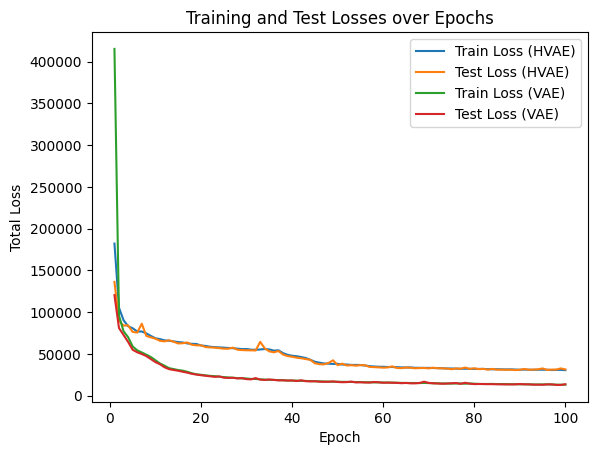

In [11]:
epochs = range(1, EPOCH + 1)

plt.plot(epochs, train_losses_hvae, label='Train Loss (HVAE)')
plt.plot(epochs, test_losses_hvae, label='Test Loss (HVAE)')

plt.plot(epochs, train_losses_vae, label='Train Loss (VAE)')
plt.plot(epochs, test_losses_vae, label='Test Loss (VAE)')

plt.legend()

plt.title('Training and Test Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')

plt.show()

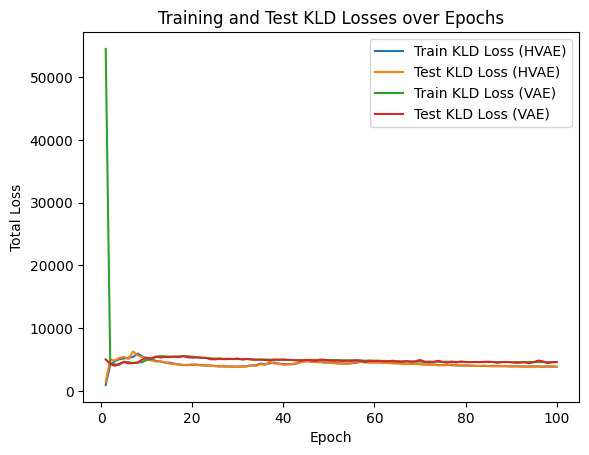

In [12]:
epochs = range(1, EPOCH + 1)

plt.plot(epochs, train_kld_hvae_list, label='Train KLD Loss (HVAE)')
plt.plot(epochs, test_kld_hvae_list, label='Test KLD Loss (HVAE)')

plt.plot(epochs, train_kld_vae_list, label='Train KLD Loss (VAE)')
plt.plot(epochs, test_kld_vae_list, label='Test KLD Loss (VAE)')

plt.legend()

plt.title('Training and Test KLD Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')

plt.show()

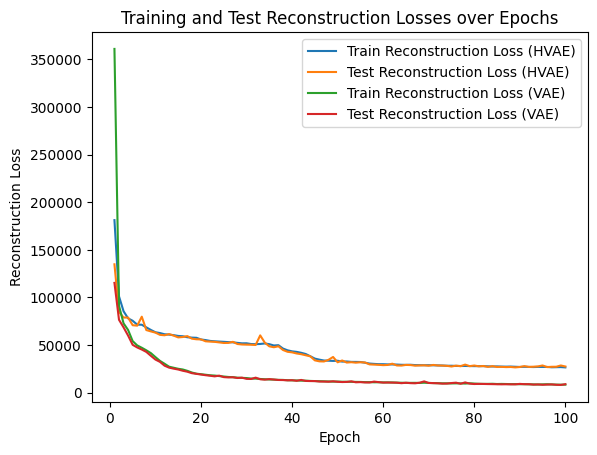

In [13]:
epochs = range(1, EPOCH + 1)

plt.plot(epochs, train_recon_hvae_list, label='Train Reconstruction Loss (HVAE)')
plt.plot(epochs, test_recon_hvae_list, label='Test Reconstruction Loss (HVAE)')

plt.plot(epochs, train_recon_vae_list, label='Train Reconstruction Loss (VAE)')
plt.plot(epochs, test_recon_vae_list, label='Test Reconstruction Loss (VAE)')

plt.legend()

plt.title('Training and Test Reconstruction Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')

plt.show()

Widzimy, że zwykły model VAE osiąga niższe wyniki niż jego odpowiednik z dodatkową warstwą w przestrzeni ukrytej (HVAE). Warto zaznaczyć, że w przypadku obu modeli czynnik straty KLD stabilizował się na podobnym poziomie. Najpewniej można by było trenować oba modele zdecydowanie dłużej, jednak nie posiadałem na to zasobów obliczeniowych. 

Sprawdziłem również jak rozmiar warstwy ukrytej wpływa na działanie modelu VAE. 

In [15]:
latent_sizes_to_check = [32, 64, 128, 256]

train_total_losses = {32: [], 64: [], 128: [], 256: []}
test_total_losses = {32: [], 64: [], 128: [], 256: []}

# Run options
LEARNING_RATE = 1.0e-3
EPOCH = 50

for latent_size in latent_sizes_to_check:
    clear_dir(f'./images_vae_latent_{latent_size}')
    model_latent_vae = VAE(latent_1_size = latent_size, beta = 1)
    optimizer_vae = torch.optim.Adam(list(model_latent_vae.parameters()), lr=LEARNING_RATE)
    
    for i in range(EPOCH):
        
        model_latent_vae.train()
        train_total_vae, train_kld_vae, train_reconstrustion_vae = train_vae(model_latent_vae, train_loader, optimizer_vae, device)
        with torch.no_grad():
            model_latent_vae.eval()
            test_total_vae, test_kld_vae, test_reconstrustion_vae = test_vae(i, model_latent_vae, test_loader, device, f'./images_vae_latent_{latent_size}')

        print("Epoch: {}/{} Train loss VAE: {}, Train KLD: {}, Train Reconstruction Loss:{}, Latent size: {}".format(i, EPOCH, train_total_vae, train_kld_vae, train_reconstrustion_vae, latent_size))
        print("Epoch: {}/{} Test loss VAE: {}, Test KLD: {}, Test Reconstruction Loss:{}, Latent size: {}".format(i, EPOCH, test_total_vae, test_kld_vae, test_reconstrustion_vae, latent_size))

        
        train_total_losses[latent_size].append([train_total_vae])
        test_total_losses[latent_size].append([test_total_vae])


Epoch: 0/50 Train loss VAE: 8430008.895298364, Train KLD: 460137.1071551356, Train Reconstruction Loss:7969871.973133373, Latent size: 32
Epoch: 0/50 Test loss VAE: 257417.65914231038, Test KLD: 6956.531421255219, Test Reconstruction Loss:250461.1272725296, Latent size: 32
Epoch: 1/50 Train loss VAE: 229802.77277052402, Train KLD: 5481.116027301045, Train Reconstruction Loss:224321.65541356136, Latent size: 32
Epoch: 1/50 Test loss VAE: 203457.94262134656, Test KLD: 3631.018782008416, Test Reconstruction Loss:199826.9232776618, Latent size: 32
Epoch: 2/50 Train loss VAE: 193897.10572339708, Train KLD: 3642.586267837473, Train Reconstruction Loss:190254.5194424407, Latent size: 32
Epoch: 2/50 Test loss VAE: 180526.5759612039, Test KLD: 3753.4823868764133, Test Reconstruction Loss:176773.09404901706, Latent size: 32
Epoch: 3/50 Train loss VAE: 174892.25845772677, Train KLD: 3413.5281636360114, Train Reconstruction Loss:171478.7301651672, Latent size: 32
Epoch: 3/50 Test loss VAE: 165195.

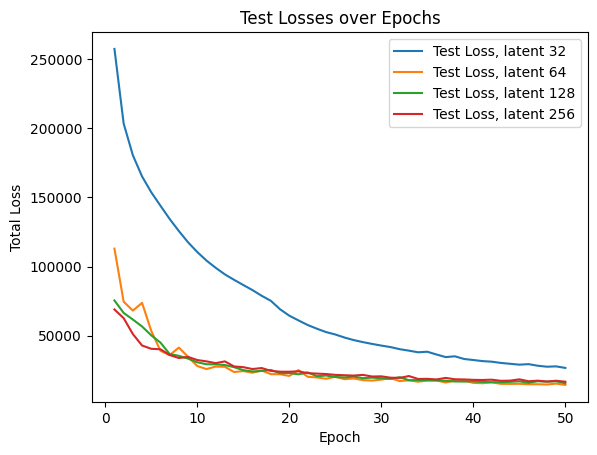

In [16]:
epochs = range(1, EPOCH + 1)

# plt.plot(epochs, train_total_losses[32], label='Train Loss, latent 32')
plt.plot(epochs, test_total_losses[32], label='Test Loss, latent 32')

# plt.plot(epochs, train_total_losses[64], label='Train Loss, latent 64')
plt.plot(epochs, test_total_losses[64], label='Test Loss, latent 64')

# plt.plot(epochs, train_total_losses[128], label='Train Loss, latent 128')
plt.plot(epochs, test_total_losses[128], label='Test Loss, latent 128')

# plt.plot(epochs, train_total_losses[256], label='Train Loss, latent 256')
plt.plot(epochs, test_total_losses[256], label='Test Loss, latent 256')

plt.legend()

plt.title('Test Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')

plt.show()

Widzimy, że większość modeli po odpowiednim czasie treningu działa całkiem podobnie. Nawet model z warstwą ukrytą o wielkości 32 najpewniej po dłuższym czasie treningu by osiągnął podobne wyniki.

Jako, że model z warstwą ukrytą o wielkości 128 porównywaliśmy już wcześniej z modelem o dwóch warstwach ukrytych (o wielkości odpowiednio 128 i 32) wiemy również, że dodanie dodatkowej warstwy nie poprawia wyników.

Sprawdzę teraz jak parametr Beta wpływa na strukturę loss-u naszych modeli oraz na ich wyniki. Będziemy testowali ten parametr na modelu z jedną warstwą ukrytą o rozmiarze 128, gdyż wcześniej osiągał on całkiem dobre wyniki.

In [15]:
betas_to_check = [0.25, 0.5, 1, 2, 4]

train_total_losses_betas = {0.125:[], 0.25: [], 0.5: [], 1:[], 2: [], 4: []}
test_total_losses_betas = {0.125:[], 0.25: [], 0.5: [], 1:[], 2: [], 4: []}

train_kld_betas = {0.125:[], 0.25: [], 0.5: [], 1:[], 2: [], 4: []}
test_kld_betas = {0.125:[], 0.25: [], 0.5: [], 1:[], 2: [], 4: []}

train_recon_betas = {0.125:[], 0.25: [], 0.5: [], 1:[], 2: [], 4: []}
test_recon_betas = {0.125:[], 0.25: [], 0.5: [], 1:[], 2: [], 4: []}

# Run options
LEARNING_RATE = 1.0e-3
EPOCH = 50

# setup model
for beta in betas_to_check:

    model_vae = VAE(latent_1_size = 32, beta = beta)
    optimizer_vae = torch.optim.Adam(list(model_vae.parameters()), lr=LEARNING_RATE)
    clear_dir(f'./images_beta_{beta}/')
    for i in range(EPOCH):
        
        model_vae.train()
        train_total_vae, train_kld_vae, train_reconstrustion_vae = train_vae(model_vae, train_loader, optimizer_vae, device)
        with torch.no_grad():
            model_vae.eval()
            test_total_vae, test_kld_vae, test_reconstrustion_vae = test_vae(i, model_vae, test_loader, device, f'./images_beta_{beta}/')

        print("Epoch: {}/{} Train loss VAE: {}, Train KLD: {}, Train Reconstruction Loss:{}, Beta: {}".format(i, EPOCH, train_total_vae, train_kld_vae, train_reconstrustion_vae, beta))
        print("Epoch: {}/{} Test loss VAE: {}, Test KLD: {}, Test Reconstruction Loss:{}, Beta: {}".format(i, EPOCH, test_total_vae, test_kld_vae, test_reconstrustion_vae, beta))

        
        train_total_losses_betas[beta].append([train_total_vae])
        test_total_losses_betas[beta].append([test_total_vae])
        train_kld_betas[beta].append([train_kld_vae])
        test_kld_betas[beta].append([test_kld_vae])
        train_recon_betas[beta].append([train_reconstrustion_vae])
        test_recon_betas[beta].append([test_reconstrustion_vae])


Epoch: 0/50 Train loss VAE: 286006.70398681273, Train KLD: 878.7729309656382, Train Reconstruction Loss:285127.93179626786, Beta: 0.25
Epoch: 0/50 Test loss VAE: 151055.74178518614, Test KLD: 210.6045998378852, Test Reconstruction Loss:150845.13539491998, Beta: 0.25
Epoch: 1/50 Train loss VAE: 94419.38475407074, Train KLD: 552.0585712715612, Train Reconstruction Loss:93867.32663676451, Beta: 0.25
Epoch: 1/50 Test loss VAE: 59367.7209137961, Test KLD: 1166.8239740147387, Test Reconstruction Loss:58200.89699406315, Beta: 0.25
Epoch: 2/50 Train loss VAE: 49345.808570075074, Train KLD: 1859.3867604643185, Train Reconstruction Loss:47486.42150033575, Beta: 0.25
Epoch: 2/50 Test loss VAE: 44378.55417917101, Test KLD: 2344.6736930576394, Test Reconstruction Loss:42033.88066229558, Beta: 0.25
Epoch: 3/50 Train loss VAE: 32552.289329890766, Train KLD: 2201.8384682040605, Train Reconstruction Loss:30350.45081935644, Beta: 0.25
Epoch: 3/50 Test loss VAE: 27735.243201439633, Test KLD: 2195.8239168

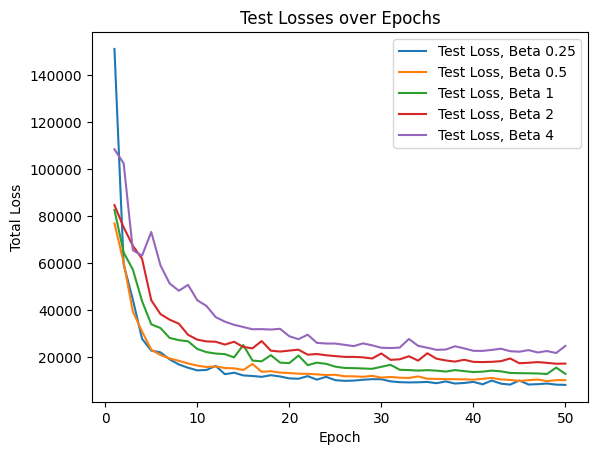

In [17]:
epochs = range(1, EPOCH + 1)

# plt.plot(epochs, train_total_losses[32], label='Train Loss, latent 32')
plt.plot(epochs, test_total_losses_betas[0.25], label='Test Loss, Beta 0.25')

# plt.plot(epochs, train_total_losses[64], label='Train Loss, latent 64')
plt.plot(epochs, test_total_losses_betas[0.5], label='Test Loss, Beta 0.5')

plt.plot(epochs, test_total_losses_betas[1], label='Test Loss, Beta 1')

# plt.plot(epochs, train_total_losses[128], label='Train Loss, latent 128')
plt.plot(epochs, test_total_losses_betas[2], label='Test Loss, Beta 2')

# plt.plot(epochs, train_total_losses[256], label='Train Loss, latent 256')
plt.plot(epochs, test_total_losses_betas[4], label='Test Loss, Beta 4')

plt.legend()

plt.title('Test Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')

plt.show()

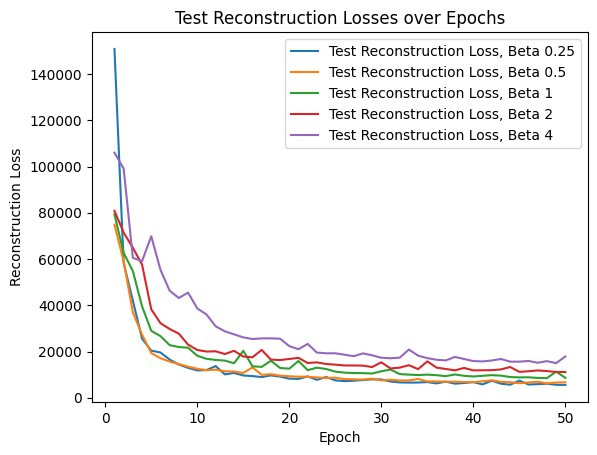

In [18]:
epochs = range(1, EPOCH + 1)

# plt.plot(epochs, train_total_losses[32], label='Train Loss, latent 32')
plt.plot(epochs, test_recon_betas[0.25], label='Test Reconstruction Loss, Beta 0.25')

# plt.plot(epochs, train_total_losses[64], label='Train Loss, latent 64')
plt.plot(epochs, test_recon_betas[0.5], label='Test Reconstruction Loss, Beta 0.5')

plt.plot(epochs, test_recon_betas[1], label='Test Reconstruction Loss, Beta 1')

# plt.plot(epochs, train_total_losses[128], label='Train Loss, latent 128')
plt.plot(epochs, test_recon_betas[2], label='Test Reconstruction Loss, Beta 2')

# plt.plot(epochs, train_total_losses[256], label='Train Loss, latent 256')
plt.plot(epochs, test_recon_betas[4], label='Test Reconstruction Loss, Beta 4')

plt.legend()

plt.title('Test Reconstruction Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')

plt.show()

Jak widać modele z wyższymi wartościami parametru Beta miały wyższe wartości straty rekonstrukcji. 

Może być to związane z tym, że model musi się bardziej "skupić" na obniżaniu czynnika straty związanego z regularyzacją.

### Task 4

Postaram się teraz sprawdzić czy mój model VAE, nauczył się w jakiś sposób rozróżniać przypadki gdzie koduje obrazek przedstawiający nowotór, od tego który przedstawia zdrowe oko.

In [8]:
from utils import only_encode_vae

EPOCH = 1

for i in range(EPOCH):
    with torch.no_grad():
        model_hvae.eval()
        points, labels = only_encode_vae(model_vae, val_loader, device)

In [9]:
concatenated_points = torch.cat(points, dim=0)
concatenated_labels = torch.cat(labels, dim=0)

In [12]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

points_pca = PCA(n_components=2).fit_transform(concatenated_points.cpu().numpy())
points_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(concatenated_points.cpu().numpy())

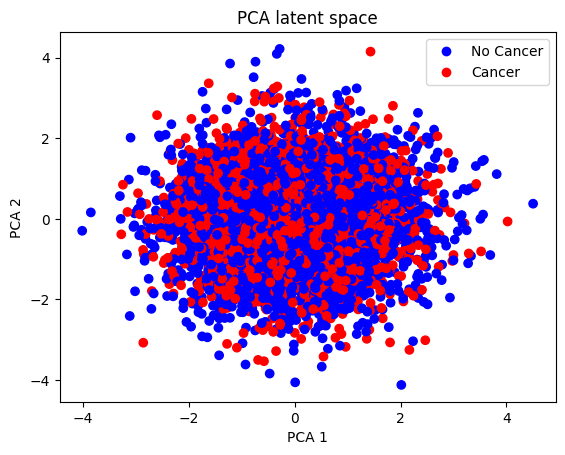

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['blue', 'red'])
scatter = plt.scatter(points_pca[:, 0], points_pca[:, 1], c=concatenated_labels.cpu(), cmap=cmap)

# Add legend
plt.legend(handles=scatter.legend_elements()[0], labels=['No Cancer', 'Cancer'], loc='upper right')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA latent space')

plt.show()


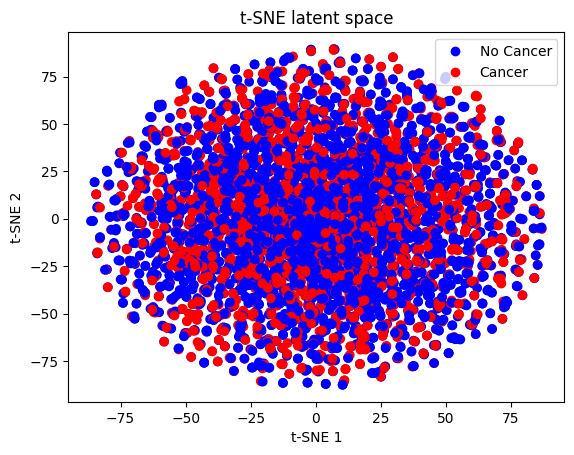

In [14]:
cmap = ListedColormap(['blue', 'red'])
scatter = plt.scatter(points_tsne[:, 0], points_tsne[:, 1], c=concatenated_labels.cpu(), cmap=cmap)

plt.legend(handles=scatter.legend_elements()[0], labels=['No Cancer', 'Cancer'], loc='upper right')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE latent space')

plt.show()


Niestety jak widać model nie jest w stanie rozróżniać obrazków na poziomie ich reprezentacji w przestrzeni ukrytej. Może być to związane z za krótkim treningiem. Model musiałby się nauczyć rozróżniać obrazki po większych szczegółach niż jest w stanie do tej pory.

Sprawdzę teraz czy któryś z wymiarów w naszej reprezentacji ukrytej odpowiada za jakąś konkretną cechę obrazka. Pokażę obrazek orginalny, a następnie będę modyfikować wartości w ich reprezentacji ukrytej i sprawdzać jak wyglądać będzie obrazek wynikowy.

Pierwszy test jaki wykonałem na każdymz 128 wymiarów nie przyniósł widocznych zmian dlatego zdecydowałem się modyfikować 10 wymiarów na raz. Zwiększam (lub obniżam) wartości na kolejnych dziesięciu wymiarach. Wynikowe zdjęcia zapisałem do folderu './images_perturbed_add10' i './images_perturbed_minus10'.

In [10]:
from utils import decode_latent_vae, perturb_dim_vae

In [11]:
sample_latent = concatenated_points[2].reshape(1, -1)
decoded_image = decode_latent_vae(model_vae, sample_latent, device)
decoded_image = decoded_image.cpu()

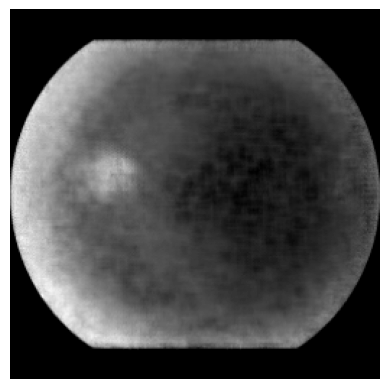

In [12]:
plt.imshow(torch.reshape(decoded_image, (256,256)), cmap='gray')
plt.axis('off')
plt.show()

The latent_space has 128 dimentions, we will try to perturb some of them and see what will happen to the result

In [13]:
perturb_dim_vae(sample_latent, device, model_vae, 10, './images_perturbed_add10/')
perturb_dim_vae(sample_latent, device, model_vae, -10, './images_perturbed_minus10/')    

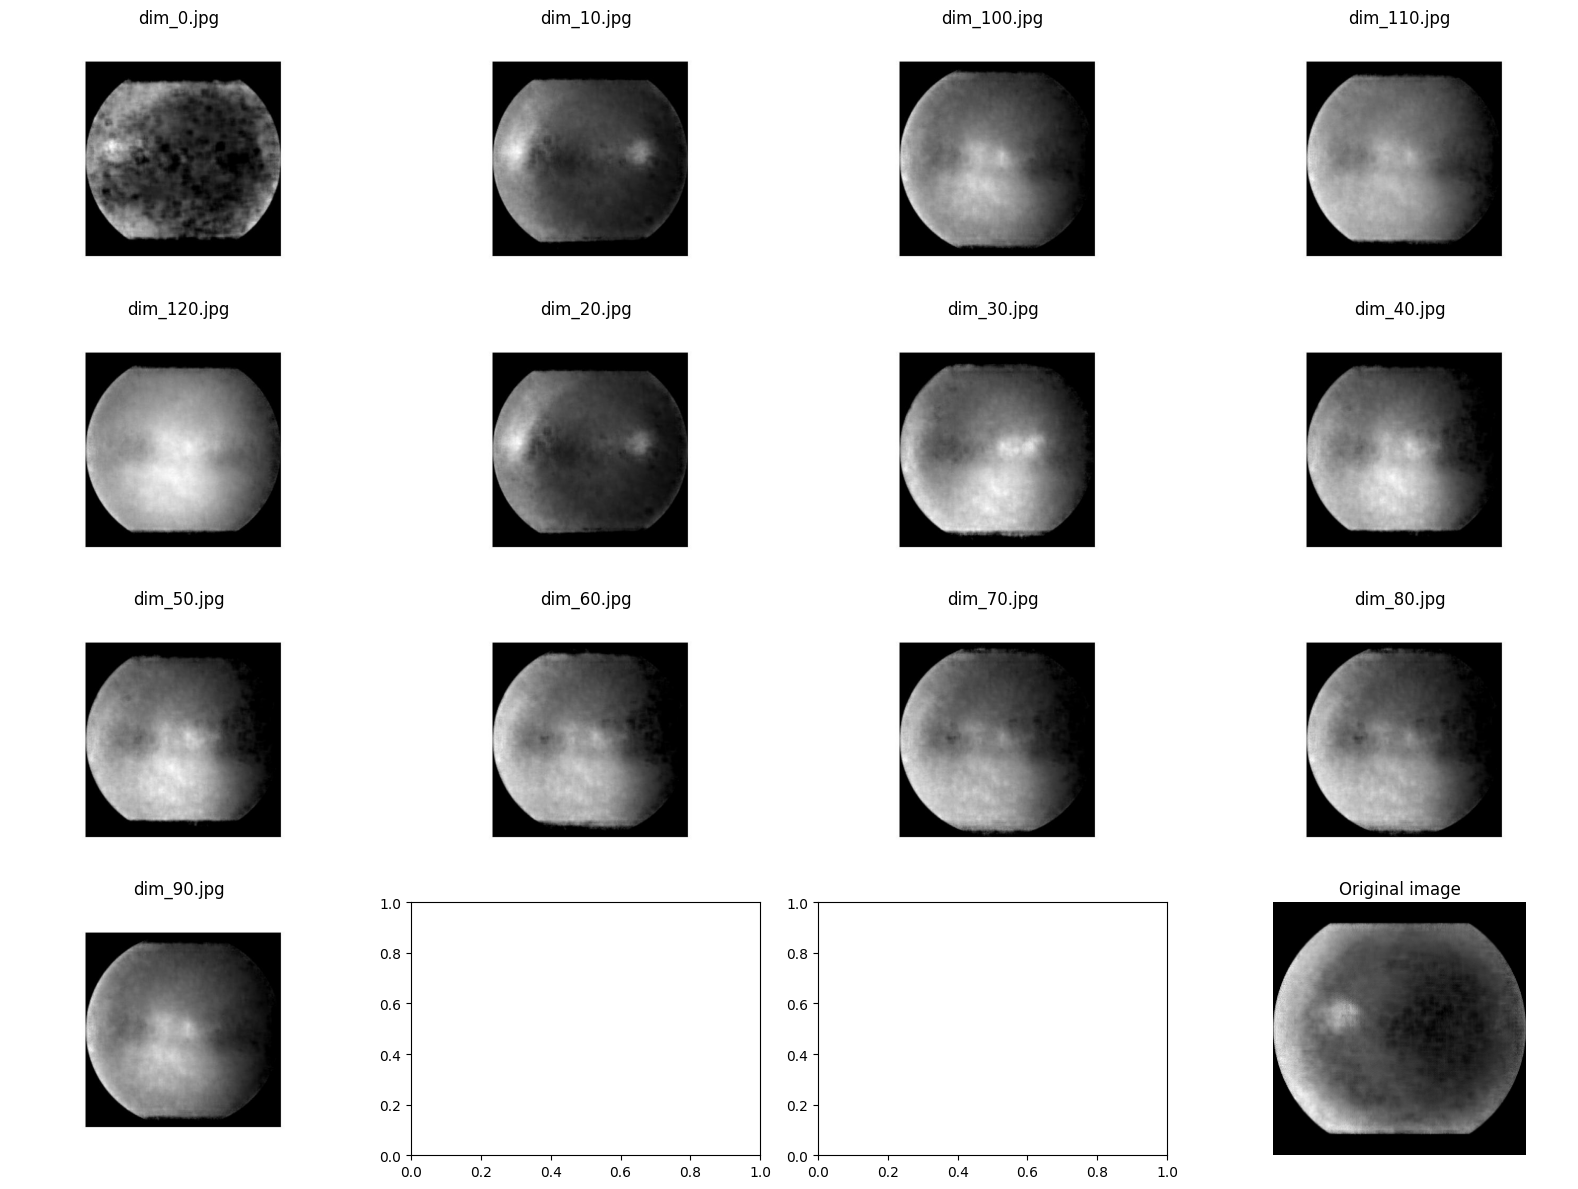

In [15]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import ceil

folder_path = './images_perturbed_add10/'
jpg_files = [file for file in os.listdir(folder_path)]
jpg_files.sort()

num_rows = ceil(len(jpg_files) / 4)

fig, axes = plt.subplots(num_rows, 4, figsize=(16, 3 * num_rows))

axes = axes.flatten()

for i, jpg_file in enumerate(jpg_files):
    image_path = os.path.join(folder_path, jpg_file)
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(jpg_file)

axes[len(axes)-1].imshow(torch.reshape(decoded_image, (256,256)), cmap='gray')
axes[len(axes)-1].axis('off')
axes[len(axes)-1].set_title("Original image")

plt.tight_layout()
plt.show()


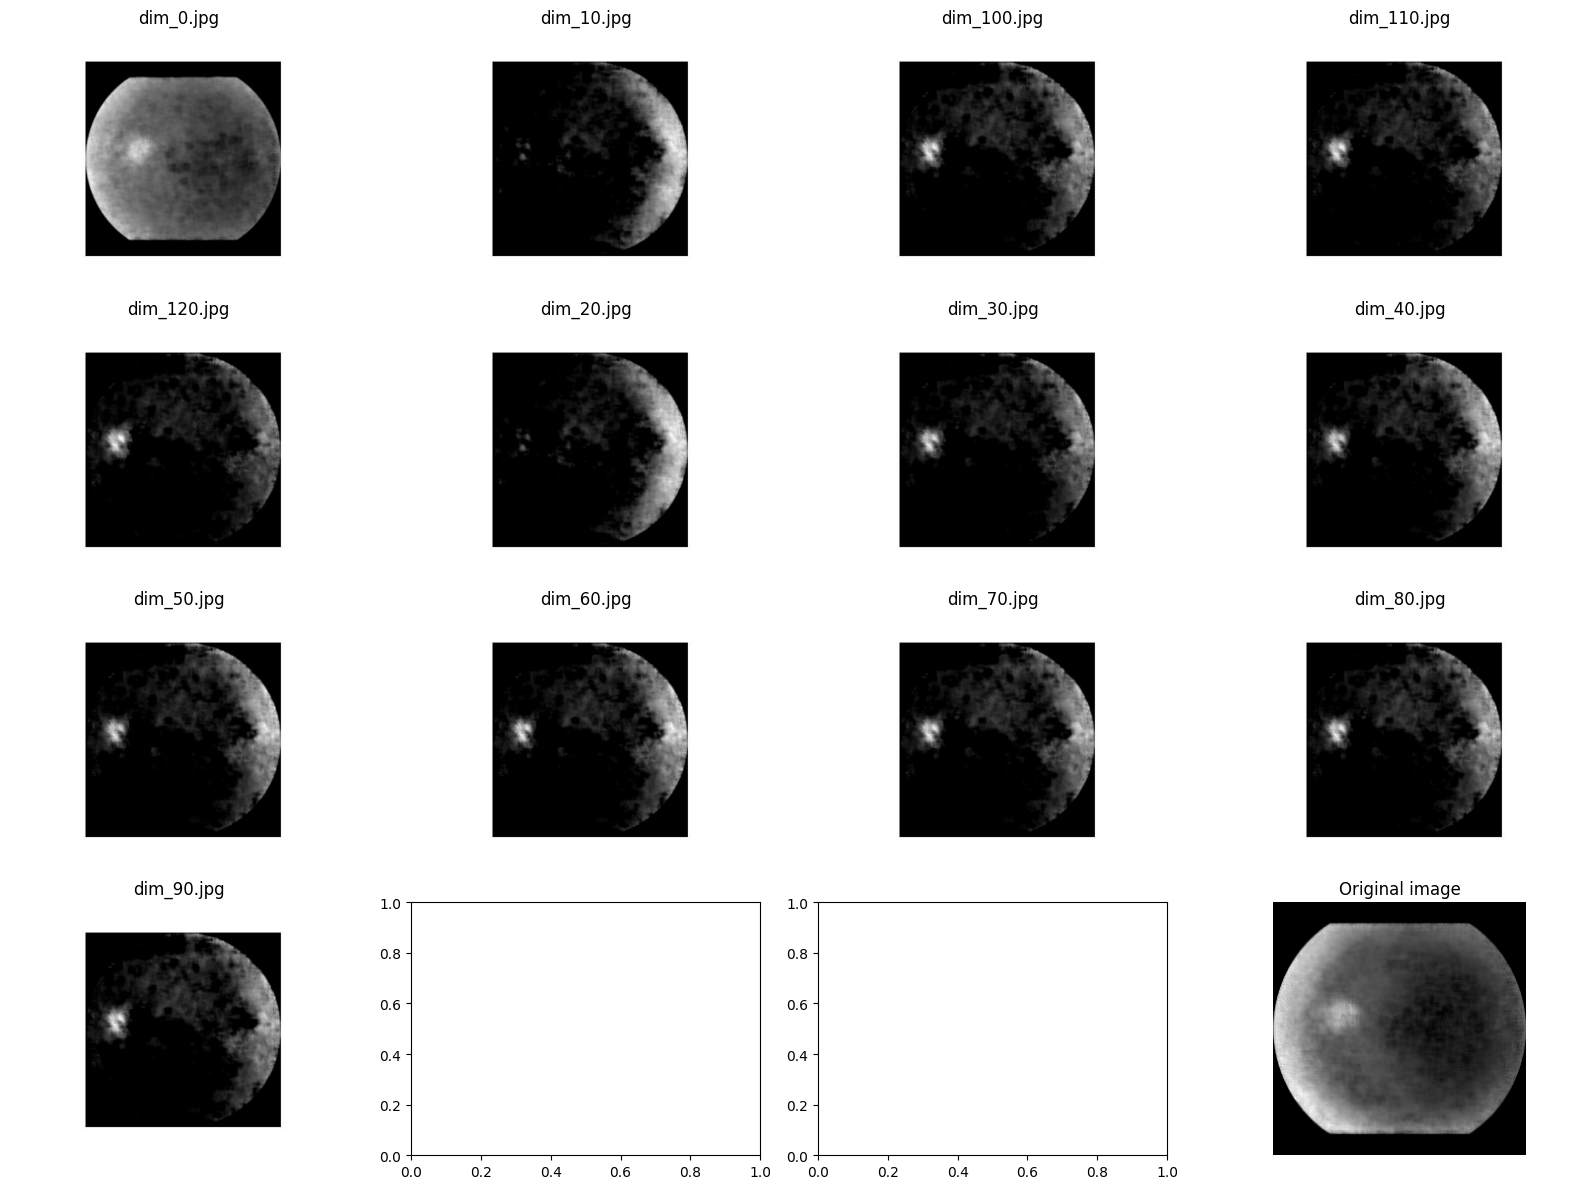

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import ceil

folder_path = './images_perturbed_minus10/'
jpg_files = [file for file in os.listdir(folder_path)]
jpg_files.sort()

num_rows = ceil(len(jpg_files) / 4)

fig, axes = plt.subplots(num_rows, 4, figsize=(16, 3 * num_rows))

axes = axes.flatten()

for i, jpg_file in enumerate(jpg_files):
    image_path = os.path.join(folder_path, jpg_file)
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(jpg_file)

axes[len(axes)-1].imshow(torch.reshape(decoded_image, (256,256)), cmap='gray')
axes[len(axes)-1].axis('off')
axes[len(axes)-1].set_title("Original image")

plt.tight_layout()
plt.show()


Jak widać na obrazkach wyżej nadal cieżko dopasować zmianę wartości reprezentacji ukrytej do konkretnej cechy, ale już widać zmiany względem orginału. Przykładowo na obrazku './images_perturbed_add10/dim_0.jpg' widzimy że podniesienie wartości pierwszych 10 wymiarów sprawia, że obrazek ma więcej czarnych plam w centrum. Obniżenie wartości w wymiarach zazwyczaj skutkuje otrzymaniem znacznie ciemniejszego obrazka. 